In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

data = pd.read_csv('pendulum_data.csv')

                     theta  theta_dot  theta_double_dot
theta             1.000000  -0.045452         -0.940972
theta_dot        -0.045452   1.000000          0.061377
theta_double_dot -0.940972   0.061377          1.000000


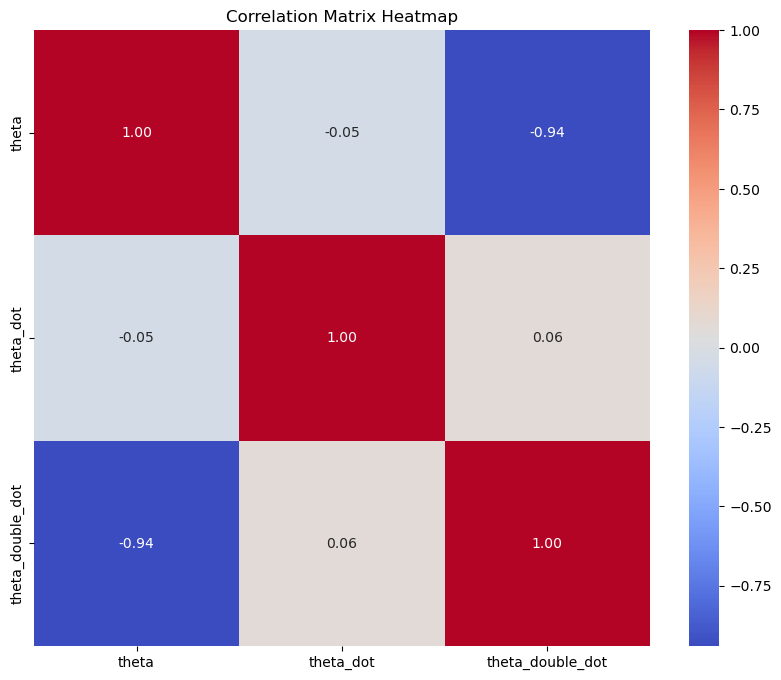

In [2]:
# Correlation matrix and heatmap

correlation_matrix = data.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

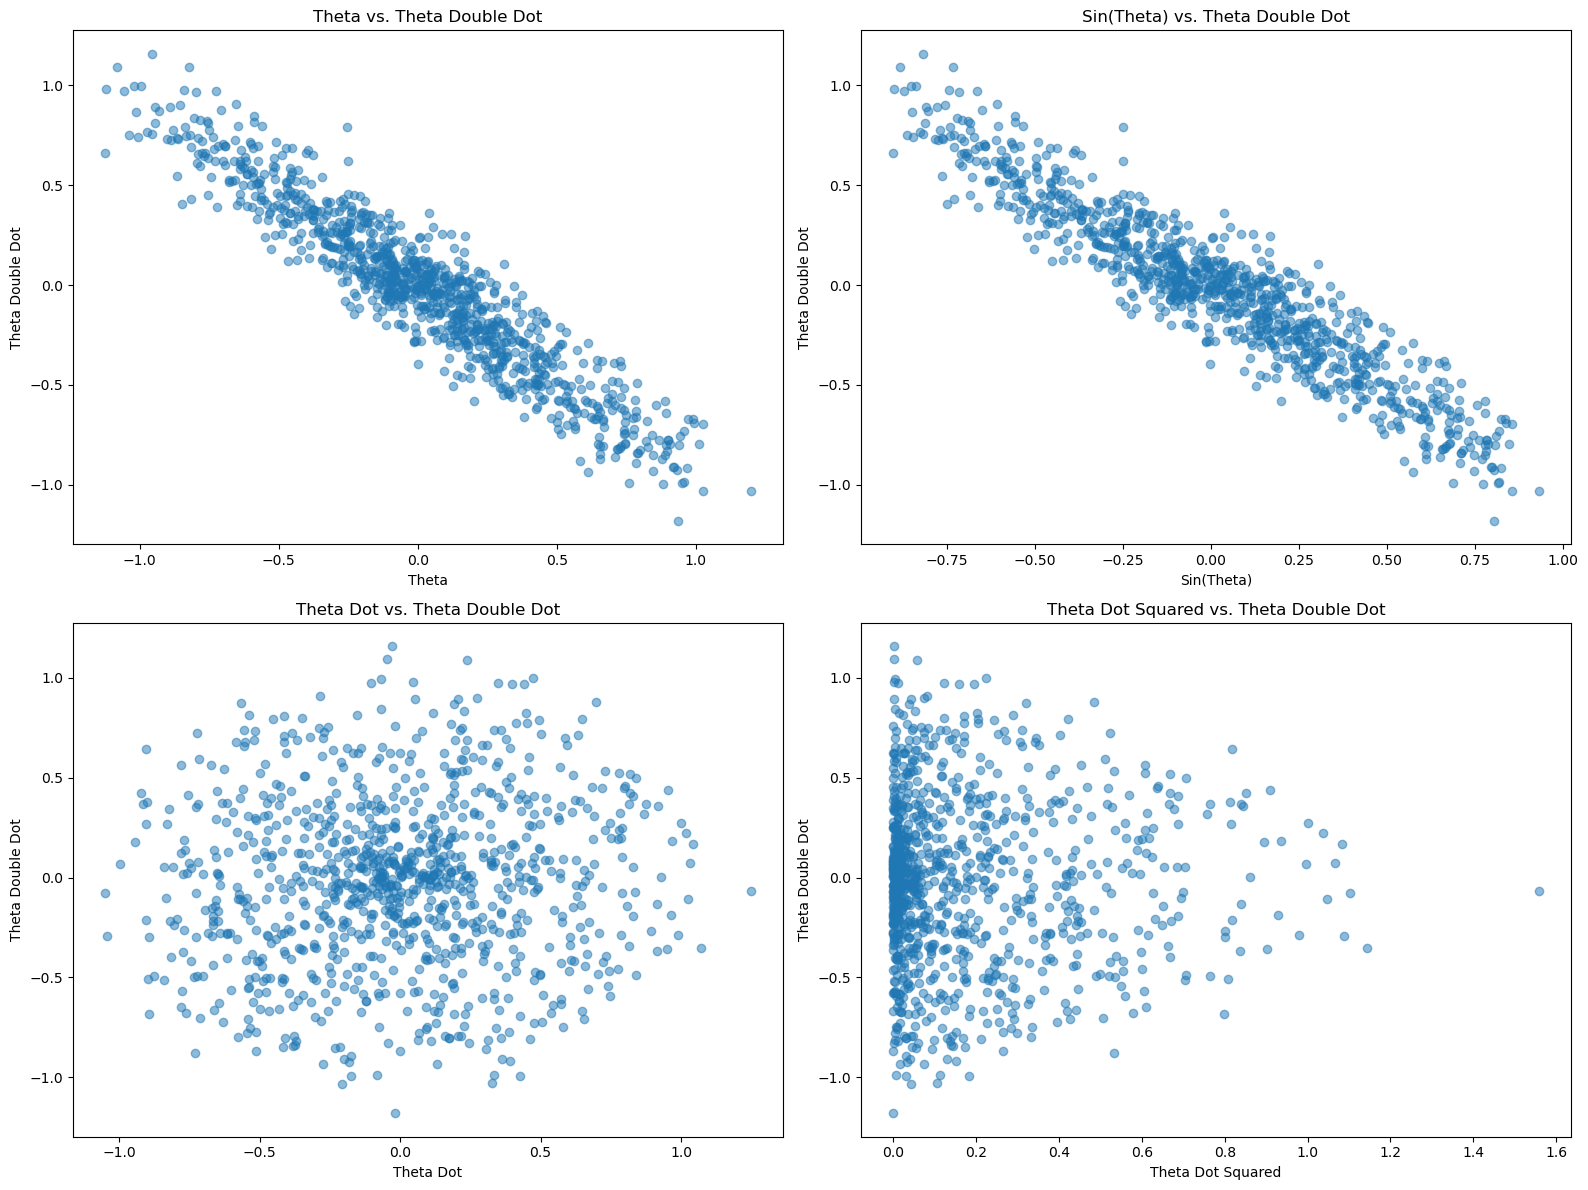

In [3]:
# Scatter plots vs. theta_double_dot

data['theta_dot_squared'] = data['theta_dot'] ** 2
data['sin_theta'] = np.sin(data['theta'])

plt.figure(figsize=(16, 12))

# Scatter plot for theta vs. theta_double_dot
plt.subplot(2, 2, 1)
plt.scatter(data['theta'], data['theta_double_dot'], alpha=0.5)
plt.title('Theta vs. Theta Double Dot')
plt.xlabel('Theta')
plt.ylabel('Theta Double Dot')

# Scatter plot for sin(theta) vs. theta_double_dot
plt.subplot(2, 2, 2)
plt.scatter(data['sin_theta'], data['theta_double_dot'], alpha=0.5)
plt.title('Sin(Theta) vs. Theta Double Dot')
plt.xlabel('Sin(Theta)')
plt.ylabel('Theta Double Dot')

# Scatter plot for theta_dot vs. theta_double_dot
plt.subplot(2, 2, 3)
plt.scatter(data['theta_dot'], data['theta_double_dot'], alpha=0.5)
plt.title('Theta Dot vs. Theta Double Dot')
plt.xlabel('Theta Dot')
plt.ylabel('Theta Double Dot')

# Scatter plot for theta_dot_squared vs. theta_double_dot
plt.subplot(2, 2, 4)
plt.scatter(data['theta_dot_squared'], data['theta_double_dot'], alpha=0.5)
plt.title('Theta Dot Squared vs. Theta Double Dot')
plt.xlabel('Theta Dot Squared')
plt.ylabel('Theta Double Dot')

plt.tight_layout()
plt.show()

In [4]:
# Line hypothesis by ridge regression to find parameters

# Line-1: theta_double_dot = a0 + a1 * theta + a2 * sin(theta) + a3 * theta_dot + a4 * theta_dot_squared

# Line-2: theta_double_dot = b0 + b1 * theta + b2 * sin(theta) + b3 * theta_dot

# Line-3: theta_double_dot = c0 + c1 * theta + c2 * theta_dot * sin(theta) + c3 * theta_dot_squared

In [5]:
# Line-1

X1 = data[['theta', 'sin_theta', 'theta_dot', 'theta_dot_squared']].values
y = data['theta_double_dot'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=1.0)
ridge.fit(X1_train, y1_train)

a0 = intercept = ridge.intercept_
a1, a2, a3, a4 = coefficients = ridge.coef_

print(f"Theta Double Dot = {a0:.6f} + {a1:.6f} * Theta + {a2:.6f} * Sin(Theta) + {a3:.6f} * Theta Dot + {a4:.6f} * Theta Dot Squared")
print(f"Parameters: a0 = {a0:.12f}, a1 = {a1:.12f}, a2 = {a2:.12f}, a3 = {a3:.12f}, a4 = {a4:.12f}")

Theta Double Dot = 0.002707 + -0.487185 * Theta + -0.461615 * Sin(Theta) + 0.030422 * Theta Dot + -0.037445 * Theta Dot Squared
Parameters: a0 = 0.002706530732, a1 = -0.487185295853, a2 = -0.461615395215, a3 = 0.030421680822, a4 = -0.037445146831


In [6]:
# Line-2

X2 = data[['theta', 'sin_theta', 'theta_dot']].values

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=1.0)
ridge.fit(X2_train, y2_train)

b0 = intercept = ridge.intercept_
b1, b2, b3 = coefficients = ridge.coef_

print(f"Theta Double Dot = {b0:.6f} + {b1:.6f} * Theta + {b2:.6f} * Sin(Theta) + {b3:.6f} * Theta Dot")
print(f"Parameters: b0 = {b0:.12f}, b1 = {b1:.12f}, b2 = {b2:.12f}, b3 = {b3:.12f}")

Theta Double Dot = -0.003900 + -0.486661 * Theta + -0.462366 * Sin(Theta) + 0.029841 * Theta Dot
Parameters: b0 = -0.003900199304, b1 = -0.486661029479, b2 = -0.462365642945, b3 = 0.029840771870


In [7]:
# Line-3

data['theta_dot_sin'] = data['theta_dot'] * data['sin_theta']
X3 = data[['theta', 'theta_dot_sin', 'theta_dot_squared']].values

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=1.0)
ridge.fit(X3_train, y3_train)

c0 = intercept = ridge.intercept_
c1, c2, c3 = coefficients = ridge.coef_

print(f"Theta Double Dot = {c0:.6f} + {c1:.6f} * Theta + {c2:.6f} * Theta Dot * Sin(Theta) + {c3:.6f} * Theta Dot Squared")
print(f"Parameters: c0 = {c0:.12f}, c1 = {c1:.12f}, c2 = {c2:.12f}, c3 = {c3:.12f}")

Theta Double Dot = 0.002151 + -0.909907 * Theta + 0.028514 * Theta Dot * Sin(Theta) + -0.035290 * Theta Dot Squared
Parameters: c0 = 0.002150812936, c1 = -0.909907473040, c2 = 0.028513635260, c3 = -0.035290328749


In [8]:
# Cross-validation by finding mean squared error and coefficient of determination

def scores(X, y):
    mse_scorer = make_scorer(mean_squared_error)
    mse_scores = cross_val_score(ridge, X, y, cv=5, scoring=mse_scorer)
    avg_mse = np.mean(mse_scores)

    r2_scorer = make_scorer(r2_score)
    r2_scores = cross_val_score(ridge, X, y, cv=5, scoring=r2_scorer)
    avg_r2 = np.mean(r2_scores)
    
    return avg_mse, avg_r2

dataset = [X1, X2, X3]
results = []

for i, X in enumerate(dataset, start=1):
    average_mse, average_r2 = scores(X, y)
    results.append([i, average_mse, average_r2])
    
print("Results:")
for i, average_mse, average_r2 in results:
    print(f"Line-{i}, Average Mean Squared Error: {average_mse:.12f}, Coefficient of Determination: {average_r2:.12f}")

Results:
Line-1, Average Mean Squared Error: 0.019872995756, Coefficient of Determination: 0.884589465608
Line-2, Average Mean Squared Error: 0.019875549086, Coefficient of Determination: 0.884564974404
Line-3, Average Mean Squared Error: 0.019963574126, Coefficient of Determination: 0.884083181696


In [9]:
# Best case by maximising r^2 or minimising mse

best_case = max(results, key=lambda x: x[2]) 

best_case_mse = best_case[1]
best_case_r2 = best_case[2]
best_case_index = best_case[0]

print(f"Best Case Line: Line-{best_case_index}")
print(f"Average Mean Squared Error: {best_case_mse:.12f}")
print(f"Coefficient of Determination: {best_case_r2:.12f}")

# Refer to the best line equation from above

Best Case Line: Line-1
Average Mean Squared Error: 0.019872995756
Coefficient of Determination: 0.884589465608
